# ŧransformation of data to improve random forest


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## -------------------------------------sk learn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [91]:
path="data/features_train.csv"
x_train_raw=pd.read_csv(path)

path = "data/target_train.csv"
y_train_raw = pd.read_csv(path)

path="data/features_test.csv"
x_test = pd.read_csv(path)

path="data/feature_importance_sorted.csv"
feat_imp=pd.read_csv(path)

In [23]:
x_train_clean =x_train_raw.drop(columns='Id')

In [24]:
X_train, x_valid, Y_train, y_valid= train_test_split(x_train_clean, y_train_raw['Expected'], test_size=0.2, random_state=11)


<AxesSubplot:>

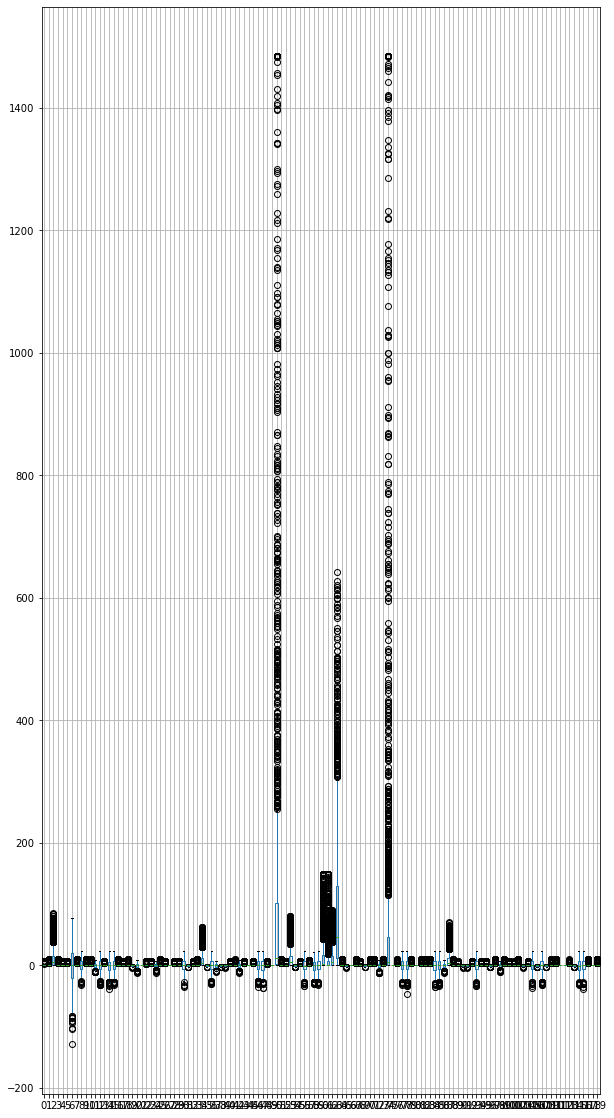

In [116]:
# exclude values beyon  given quantile
down_quant=0
up_quant=.99

X_no_out=[]
for i in x_train_clean.columns:
    temp_series =X_train[i]
    X_no_out.append(temp_series[temp_series.between(temp_series.quantile(down_quant), temp_series.quantile(up_quant))]) # without outliers

x_no_out_df=pd.DataFrame({'Id':x_train_raw.index.to_list()})
x_no_out_df

for i in X_no_out:
    x_no_out_df = pd.concat([x_no_out_df, i], axis=1)

x_no_out_df.head()

x_no_out_df = x_no_out_df.dropna().drop(columns=['Id'])

fig, ax=plt.subplots(figsize=(10,20))
x_no_out_df.boxplot(ax=ax)

In [67]:
x_no_out_df.head()

,Id,0,1,2,3,4,5,6,7,8,...,110,111,112,113,114,115,116,117,118,119
7,7,0.010046,0.229306,4.009751,0.727105,0.000433,0.008759,26.635944,5.087996,5.952485,...,0.204028,0.019983,0.097477,2.964062,0.449843,8.173558,20.835307,0.466732,0.459114,1.212549
9,9,0.157382,1.067279,3.456239,0.056444,0.002137,0.010691,16.523108,3.937696,0.801355,...,3.337579,0.250173,0.643348,2.485729,0.058090,3.981239,3.689334,4.761166,0.101749,2.178764
10,10,0.180210,0.384282,7.330681,0.623692,0.561286,5.203580,-30.621884,1.153701,-6.593711,...,1.753957,0.338777,0.913739,0.829268,-1.077371,8.285425,16.594383,0.438735,0.191070,0.372427
11,11,0.199610,3.154566,0.752633,1.127864,0.003370,0.035406,0.293269,5.353501,-22.494508,...,4.023090,0.750237,0.358472,5.835492,0.431855,16.801314,-11.571271,0.827301,0.588532,1.863355
22,22,0.373425,0.281921,0.061531,3.485045,0.615822,0.003468,15.056074,1.105871,-0.502368,...,2.351652,0.007636,0.041104,1.691281,0.779381,6.537409,14.482692,0.479201,0.276321,9.663936


In [126]:
# filter features and rows
# removign outliers
"""sel_x = x_no_out_df

sel_y= Y_train.loc[sel_x.index]
sel_x.shape, sel_y.shape
"""
# getting important features
str_list= [str(i) for i in feat_imp['feature'].to_list()[0:20]]
sel_x = X_train[str_list]

x_valid_sel=x_valid[str_list]

In [107]:
# functions to run parameter optimisation
def rd_optimise_model(model, params_dic, metric):
    pipe=make_pipeline(model)
    gs = RandomizedSearchCV(pipe, params_dic, scoring=metric, n_iter=10, n_jobs=-1, cv=10)
    gs.fit(sel_x,Y_train)
    return gs

def grid_optimise_model(model, params_dic, metric):
    pipe=make_pipeline(ct, model)
    gs = GridSearchCV(pipe, params_dic, scoring=metric, n_jobs=4, cv=5)
    gs.fit(sel_x,Y_train)
    return gs

In [75]:

 # searching for random forest parameters
RF = RandomForestClassifier()
params_dic={"randomforestclassifier__max_depth" : np.linspace(5,50,20).astype(int),
            "randomforestclassifier__min_samples_split" : np.linspace(0.1,0.9,20),
            "randomforestclassifier__max_leaf_nodes" : np.linspace(2,50,10).astype(int),
            "randomforestclassifier__min_samples_leaf":np.linspace(10,30,10).astype(int),
            "randomforestclassifier__n_estimators" :np.linspace(1,200, 50).astype(int),
            "randomforestclassifier__max_features" : np.linspace(1,18, 18).astype(int)
           }

rd_RF=rd_optimise_model(RF,params_dic, 'f1_macro')

rd_RF.best_params_, rd_RF.best_score_

({'randomforestclassifier__n_estimators': 167,
  'randomforestclassifier__min_samples_split': 0.1,
  'randomforestclassifier__min_samples_leaf': 18,
  'randomforestclassifier__max_leaf_nodes': 34,
  'randomforestclassifier__max_features': 7,
  'randomforestclassifier__max_depth': 40},
 0.4448154677466108)

In [ ]:
from xgboost import XGBClassifier
XGB = XGBClassifier()

params_dic = [
    {
        "xgbclassifier__learning_rate": np.around(np.linspace(0.01, 0.08, 15), decimals=3),
        "xgbclassifier__n_estimators": np.linspace(50, 1200, 20).astype(int),
        "xgbclassifier__max_depth": range(2, 15),
        "xgbclassifier__min_child_weight": [0, 1, 2, 3, 4, 5],
    }]

rd_XGB = rd_optimise_model(XGB, params_dic, 'f1_macro')

In [ ]:
rd_XGB.best_params_, rd_XGB.best_score_

In [108]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
"""PARAMETERS for KNN
n_neighbors=5,
*,
weights='uniform',
algorithm='auto',
leaf_size=30,
p=2,
metric='minkowski',
metric_params=None,
n_jobs=None,
)"""

knn = KNeighborsClassifier()
params_dic={'kneighborsclassifier__n_neighbors':list(range(1,200, 30)),
            'kneighborsclassifier__weights':['uniform', 'distance'], 
            "kneighborsclassifier__metric": ['euclidean', 'manhattan', 'chebyshev', 'minkowsky', 'wminkowsky', 'seuclidean', 'mahalanobis']}

knn_gs = rd_optimise_model(knn, params_dic, 'f1_macro')

knn_gs.best_score_, knn_gs.best_params_

(0.40949254554710385,
 {'kneighborsclassifier__weights': 'distance',
  'kneighborsclassifier__n_neighbors': 181,
  'kneighborsclassifier__metric': 'manhattan'})

In [110]:
# grid optimise XGB parameters
XGB = XGBClassifier()

params_dic = [
    {
        "xgbclassifier__learning_rate": np.around(np.linspace(0.001, 1, 5), decimals=3),
        "xgbclassifier__n_estimators": np.linspace(80, 120, 5).astype(int),
        "xgbclassifier__max_depth": np.linspace(5, 200, 5).astype(int),
        "xgbclassifier__min_child_weight": np.linspace(5, 30,5).astype(int),
        "xgbclassifier__booster": ['gbtree', 'gblinear', 'dart']
    
    }]

rd_XGB = rd_optimise_model(XGB, params_dic, 'f1_macro')

In [112]:
rd_XGB.best_score_, rd_XGB.best_params_

(0.6427310616256194,
 {'xgbclassifier__n_estimators': 90,
  'xgbclassifier__min_child_weight': 11,
  'xgbclassifier__max_depth': 151,
  'xgbclassifier__learning_rate': 0.75,
  'xgbclassifier__booster': 'dart'})

              precision    recall  f1-score   support

           0       0.66      0.65      0.65       667
           1       0.66      0.68      0.67       656
           2       0.64      0.63      0.63       677

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



<AxesSubplot:>

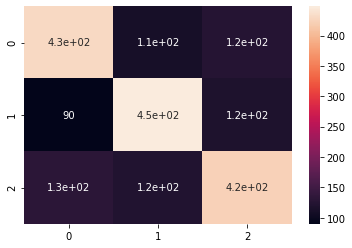

In [128]:
# OPTIMISED MODEL WITH BEST SCORE
""" {'xgbclassifier__n_estimators': 90,
  'xgbclassifier__min_child_weight': 11,
  'xgbclassifier__max_depth': 151,
  'xgbclassifier__learning_rate': 0.75,
  'xgbclassifier__booster': 'dart'}) """

model=XGBClassifier(n_estimators=90, min_child_weight=11, max_depth=151, learning_rate=0.75, booster="dart")

model.fit(sel_x, Y_train)
y_pred = model.predict(x_valid_sel)
print(classification_report(y_valid,y_pred))
c_m=confusion_matrix(y_valid, y_pred)
sns.heatmap(c_m, annot=c_m)

In [136]:
# examining false positives and false negatives in testing dataset

col=str_list[0]
pred_vs_true = pd.DataFrame({'predicted':y_pred, 'true': y_valid})
false_df=pred_vs_true[pred_vs_true['predicted']!=pred_vs_true['true']]
pred_vs_true

In [146]:
# running prediction on test dataset

path="data/features_test.csv"
x_test = pd.read_csv(path)

# considering only important features defined through feature importance
str_list= [str(i) for i in feat_imp['feature'].to_list()[0:20]]
sel_x_train = x_train_raw[str_list]
sel_x_test = x_test[str_list]

#run the model
model=XGBClassifier(n_estimators=90, min_child_weight=11, max_depth=151, learning_rate=0.75, booster="dart")
# fit on training data
model.fit(sel_x_train, y_train_raw['Expected'])
#predict on testing data
pred_y = model.predict(sel_x_test)
# export predictions as csv
final= pd.DataFrame({'Id':sel_x_test.index.to_list(), 'Predicted': pred_y}).reset_index()
final.iloc[:,2:3].to_csv("Prediction_final_MJR_MW.csv")